# Augmented Distillation - Binary Classification
In this example, we will use the [Adult Census Income](https://www.kaggle.com/uciml/adult-census-income). 
based on the paper

## Setup

In [293]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('../.')
sys.path.append('../conformal_pred')

## EDA

In [178]:
csv_path = Path(r"C:\Users\orrav\Documents\Datasets\Adult Census Income\adult.csv")

df = pd.read_csv(csv_path)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### Set ? to NaNs

In [180]:
df[df == '?'] = np.nan

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### Fill-out missing values
We can see that `workclass`, `occupation` and `native.country` have missing values. These features are categorical and we can therefore fill them out with `mode`.



In [182]:
for col in ['workclass', 'occupation', 'native.country']:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [184]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

### Setting features and target variables

In [185]:
X = df.drop(['income'], axis=1)

y = df['income'].map({'<=50K': 0, '>50K': 1})

### Test splitting

In [186]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [187]:
pX_train, pX_test = X_train.copy(), X_test.copy()

### Feature engineering

We'll be using `LabelEncoder` to encode categorical text features into integers. We also a standard normalization of the tabular features in the form of centering and std scaling.

In [188]:
from sklearn import preprocessing

categorical = X.select_dtypes(include=["object"]).columns
label_encoders = []
for feature in categorical:
        label_enc = preprocessing.LabelEncoder()
        pX_train.loc[:, feature] = label_enc.fit_transform(X_train[feature])
        pX_test.loc[:, feature] = label_enc.transform(X_test[feature])
        label_encoders.append(label_enc)

In [189]:
pX_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
7872,64,3,321166,9,13,0,11,1,4,0,0,0,5,38
31180,31,1,94991,11,9,0,7,4,0,1,0,0,40,38
25875,25,3,44363,11,9,4,5,1,4,1,0,0,35,38
4345,37,3,254202,9,13,2,11,0,4,1,0,0,50,38
15278,63,3,237620,11,9,2,2,0,4,1,0,0,30,38


In [190]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pX_train = pd.DataFrame(scaler.fit_transform(pX_train), columns=X.columns)
pX_test = pd.DataFrame(scaler.transform(pX_test), columns=X.columns)

In [191]:
pX_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1.850713,-0.088376,1.246786,-0.332697,1.135385,-1.742386,1.236648,-0.276827,0.393160,-1.434521,-0.14426,-0.217063,-2.885649,0.260859
1,-0.560269,-1.889076,-0.891714,0.185015,-0.421692,-1.742386,0.230318,1.590090,-4.327948,0.697097,-0.14426,-0.217063,-0.042075,0.260859
2,-0.998630,-0.088376,-1.370405,0.185015,-0.421692,0.921843,-0.272846,-0.276827,0.393160,0.697097,-0.14426,-0.217063,-0.448300,0.260859
3,-0.121909,-0.088376,0.613637,-0.332697,1.135385,-0.410272,1.236648,-0.899132,0.393160,0.697097,-0.14426,-0.217063,0.770375,0.260859
4,1.777653,-0.088376,0.456853,0.185015,-0.421692,-0.410272,-1.027593,-0.899132,0.393160,0.697097,-0.14426,-0.217063,-0.854525,0.260859


In [303]:
pX_train.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
dtype: int64

As seen by the plot below, the two classes (smaller or larger than a 50k income) are slightly imbalanced. Therefore, we chose a *macro-F1* as our measure of success for this task.

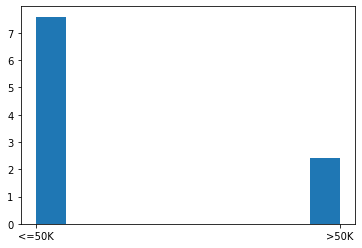

In [193]:
plt.hist(df['income'], density=True)
plt.show()

## Fit Student

First, let's fit a **Random Forest** classifier as our student model. We set `n_estimators` as default of 100 estimators.

In [194]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score

In [362]:
clf = RandomForestClassifier(random_state=0)
clf.fit(pX_train, y_train)

RandomForestClassifier(random_state=0)

In [363]:
test_preds = clf.predict(pX_test)
test_probas = clf.predict_proba(pX_test)[:, 1]

### Metrics
Macro-F1 and ROC-AUC

In [364]:
f1_score(y_test, test_preds, average='macro')

0.7885469091492391

In [365]:
roc_auc_score(y_test, test_probas)

0.903020760693811

## Fit Teacher (AutoGluon)

For the teacher model, we'll be using [AutoGluon](https://auto.gluon.ai/stable/index.html), which is an intuitive AutoML framework for multiple applications, including tabular data.

In [215]:
import graphviz
from autogluon.tabular import TabularDataset, TabularPredictor

In [216]:
label = 'income'
df_train = pX_train.copy()
df_train[label] = y_train.reset_index(drop=True)
df_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,1.850713,-0.088376,1.246786,-0.332697,1.135385,-1.742386,1.236648,-0.276827,0.393160,-1.434521,-0.14426,-0.217063,-2.885649,0.260859,0
1,-0.560269,-1.889076,-0.891714,0.185015,-0.421692,-1.742386,0.230318,1.590090,-4.327948,0.697097,-0.14426,-0.217063,-0.042075,0.260859,0
2,-0.998630,-0.088376,-1.370405,0.185015,-0.421692,0.921843,-0.272846,-0.276827,0.393160,0.697097,-0.14426,-0.217063,-0.448300,0.260859,0
3,-0.121909,-0.088376,0.613637,-0.332697,1.135385,-0.410272,1.236648,-0.899132,0.393160,0.697097,-0.14426,-0.217063,0.770375,0.260859,0
4,1.777653,-0.088376,0.456853,0.185015,-0.421692,-0.410272,-1.027593,-0.899132,0.393160,0.697097,-0.14426,-0.217063,-0.854525,0.260859,0


In [217]:
df_test = pX_test.copy()
df_test[label] = y_test.reset_index(drop=True)
df_test.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,1.266233,-0.088376,0.805319,-1.109266,-1.978770,2.253958,1.236648,1.590090,0.393160,-1.434521,-0.14426,-0.217063,-0.042075,0.260859,0
1,-1.436990,-0.088376,0.455293,0.185015,-0.421692,0.921843,-0.272846,0.967785,0.393160,-1.434521,-0.14426,-0.217063,-1.260750,0.260859,0
2,-1.144750,-0.088376,-0.603334,1.220441,-0.032423,0.921843,0.230318,-0.276827,-3.147671,-1.434521,-0.14426,-0.217063,-0.448300,0.426445,0
3,-0.121909,-2.789426,-1.328652,-0.332697,1.135385,-0.410272,0.733483,-0.899132,0.393160,0.697097,-0.14426,-0.217063,-0.042075,0.260859,0
4,0.754812,-0.088376,2.211732,0.443872,1.524654,-0.410272,1.236648,-0.899132,0.393160,0.697097,-0.14426,-0.217063,0.770375,0.260859,1


In [218]:
time_limit = 600  # for quick demonstration only, you should set this to longest time you are willing to wait (in seconds)
metric = 'f1_macro'  # specify your evaluation metric here
predictor = TabularPredictor(label, eval_metric=metric).fit(df_train, time_limit=time_limit, presets='best_quality', auto_stack=True)
predictor.leaderboard(df_test, silent=True)

No path specified. Models will be saved in: "AutogluonModels/ag-20210729_173830\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20210729_173830\"
AutoGluon Version:  0.2.0
Train Data Rows:    16280
Train Data Columns: 14
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1357.43 MB
	Train Data (Original)  Memory Usage: 1.82 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set fe

[20:45:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


	0.8209	 = Validation f1_macro score
	12.54s	 = Training runtime
	0.03s	 = Validation runtime
Fitting model: KNeighborsUnif_BAG_L2 ... Training model for up to 187.32s of the 187.31s of remaining time.
	0.7833	 = Validation f1_macro score
	0.02s	 = Training runtime
	11.89s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L2 ... Training model for up to 175.1s of the 175.09s of remaining time.
	0.7899	 = Validation f1_macro score
	0.03s	 = Training runtime
	12.28s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 162.15s of the 162.14s of remaining time.
	Ran out of time, early stopping on iteration 270. Best iteration is:
	[236]	train_set's binary_logloss: 0.229563	train_set's f1_macro: 0.842545	valid_set's binary_logloss: 0.280318	valid_set's f1_macro: 0.822384
	0.8212	 = Validation f1_macro score
	103.95s	 = Training runtime
	0.17s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 57.48s of the 57.47s of remaini

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L1,0.812143,0.820893,1.269042,0.164297,115.175212,1.269042,0.164297,115.175212,1,True,4
1,WeightedEnsemble_L2,0.812143,0.820893,1.287089,0.190620,127.719201,0.018047,0.026323,12.543988,2,True,10
2,LightGBMXT_BAG_L2,0.810541,0.821249,17.175383,9.447351,463.249604,0.973044,0.173998,103.950102,2,True,13
3,LightGBM_BAG_L2,0.810262,0.821252,16.838339,9.402344,414.521981,0.636000,0.128991,55.222479,2,True,14
4,WeightedEnsemble_L3,0.810262,0.821252,16.845339,9.462841,419.063154,0.007000,0.060496,4.541173,3,True,15
5,LightGBMXT_BAG_L1,0.806434,0.811167,2.096051,0.256811,150.067877,2.096051,0.256811,150.067877,1,True,3
6,RandomForestEntr_BAG_L1,0.791752,0.793519,0.373015,0.985082,3.244593,0.373015,0.985082,3.244593,1,True,6
7,RandomForestGini_BAG_L1,0.791192,0.794653,0.369169,1.204760,2.975086,0.369169,1.204760,2.975086,1,True,5
8,NeuralNetFastAI_BAG_L1,0.786272,0.783351,3.943187,0.759061,83.422577,3.943187,0.759061,83.422577,1,True,9
9,ExtraTreesGini_BAG_L1,0.782449,0.785431,0.803378,1.161732,2.279531,0.803378,1.161732,2.279531,1,True,7


## Augment training samples for distillation

Training the student on an augmeneted training set, should reduce the approximation error between the teacher and the student, and should therefore lead to better results at the same computational cost. The augmentation procedure is composed of two main stages:
1. For all features $i$, estimate the conditional distribution $p(x^i | x^{-i})$ using the training data.
2. Sample new features

The conditional ditribution estimation is done via a Self-Attention mechanism trained with a pseudolikelihood objective. When sampling, we compare between two methods. The first method, and the one presented in the paper is Gibbs sampling, which aims to estimate $p(x)$ directly. The second method, is simply by using the output of the Self-Attention model, which estimated the conditioal distribution of each feature.

In [26]:
import torch
from torch.utils.data import DataLoader
from models.transformer import CondEncoder

In [27]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_obj):

        # data size
        self.N = data_obj.shape[0]
        self.data = data_obj.astype(np.float32)

    def __getitem__(self, idx):
        x = self.data[idx]
        return x

    def __len__(self):
        return self.N

In [28]:
ds_train = Dataset(data_obj=pX_train.to_numpy())
train_loader = DataLoader(ds_train, batch_size=100, shuffle=True)

### Training the PL conditionals estimator
`CondEncoder` represents the self-attention-based encoder and is trained by minimized the negative log-likelihood of the conditionals. Each conditional is paramterized as a mixture of Gaussians.

In [29]:
cond_enc = CondEncoder(epochs=2000)

In [30]:
cond_enc.fit(train_loader)


Epoch: 0
Train Log likelihood, step 0 in nats: -0.102535
Train Log likelihood, step 1 in nats: -0.093035
Train Log likelihood, step 50 in nats: -0.095521
Train Log likelihood, step 100 in nats: -0.093183
Train Log likelihood, step 150 in nats: -0.092472
Train epoch average loss: -0.09266250707593539


Epoch: 1
Train Log likelihood, step 200 in nats: -0.093120
Train Log likelihood, step 250 in nats: -0.093278
Train Log likelihood, step 300 in nats: -0.093106
Train epoch average loss: -0.09255757114371738


Epoch: 2
Train Log likelihood, step 350 in nats: -0.091568
Train Log likelihood, step 400 in nats: -0.090144
Train Log likelihood, step 450 in nats: -0.089954
Train epoch average loss: -0.08950587984092112


Epoch: 3
Train Log likelihood, step 500 in nats: -0.088979
Train Log likelihood, step 550 in nats: -0.088943
Train Log likelihood, step 600 in nats: -0.088255
Train Log likelihood, step 650 in nats: -0.087232
Train epoch average loss: -0.0872013487242144


Epoch: 4
Train Log like

Train Log likelihood, step 5950 in nats: -0.035638
Train Log likelihood, step 6000 in nats: -0.035518
Train epoch average loss: -0.035174586015483


Epoch: 37
Train Log likelihood, step 6050 in nats: -0.035070
Train Log likelihood, step 6100 in nats: -0.034712
Train Log likelihood, step 6150 in nats: -0.034438
Train epoch average loss: -0.03419791115572529


Epoch: 38
Train Log likelihood, step 6200 in nats: -0.034141
Train Log likelihood, step 6250 in nats: -0.033829
Train Log likelihood, step 6300 in nats: -0.033390
Train Log likelihood, step 6350 in nats: -0.033132
Train epoch average loss: -0.03302971835849633


Epoch: 39
Train Log likelihood, step 6400 in nats: -0.032741
Train Log likelihood, step 6450 in nats: -0.032594
Train Log likelihood, step 6500 in nats: -0.032439
Train epoch average loss: -0.03241670292316472


Epoch: 40
Train Log likelihood, step 6550 in nats: -0.032194
Train Log likelihood, step 6600 in nats: -0.031951
Train Log likelihood, step 6650 in nats: -0.031862
T

Train Log likelihood, step 11850 in nats: -0.011979
Train epoch average loss: -0.011775642077722748


Epoch: 73
Train Log likelihood, step 11900 in nats: -0.011774
Train Log likelihood, step 11950 in nats: -0.011604
Train Log likelihood, step 12000 in nats: -0.011433
Train Log likelihood, step 12050 in nats: -0.011337
Train epoch average loss: -0.011293036698564284


Epoch: 74
Train Log likelihood, step 12100 in nats: -0.011151
Train Log likelihood, step 12150 in nats: -0.011114
Train Log likelihood, step 12200 in nats: -0.010903
Train epoch average loss: -0.010841592280482485


Epoch: 75
Train Log likelihood, step 12250 in nats: -0.010782
Train Log likelihood, step 12300 in nats: -0.010636
Train Log likelihood, step 12350 in nats: -0.010459
Train epoch average loss: -0.010355162697731119


Epoch: 76
Train Log likelihood, step 12400 in nats: -0.010323
Train Log likelihood, step 12450 in nats: -0.010167
Train Log likelihood, step 12500 in nats: -0.010011
Train Log likelihood, step 12550

Train Log likelihood, step 17700 in nats: 0.003162
Train Log likelihood, step 17750 in nats: 0.003277
Train epoch average loss: 0.003345023765283334


Epoch: 109
Train Log likelihood, step 17800 in nats: 0.003411
Train Log likelihood, step 17850 in nats: 0.003498
Train Log likelihood, step 17900 in nats: 0.003595
Train epoch average loss: 0.0036723539462616356


Epoch: 110
Train Log likelihood, step 17950 in nats: 0.003691
Train Log likelihood, step 18000 in nats: 0.003765
Train Log likelihood, step 18050 in nats: 0.003858
Train epoch average loss: 0.003955204404202327


Epoch: 111
Train Log likelihood, step 18100 in nats: 0.003986
Train Log likelihood, step 18150 in nats: 0.004124
Train Log likelihood, step 18200 in nats: 0.004206
Train Log likelihood, step 18250 in nats: 0.004358
Train epoch average loss: 0.004366010484403661


Epoch: 112
Train Log likelihood, step 18300 in nats: 0.004407
Train Log likelihood, step 18350 in nats: 0.004489
Train Log likelihood, step 18400 in nats: 0.0

Train epoch average loss: 0.01456858817135405


Epoch: 145
Train Log likelihood, step 23650 in nats: 0.014575
Train Log likelihood, step 23700 in nats: 0.014632
Train Log likelihood, step 23750 in nats: 0.014673
Train epoch average loss: 0.014772140180386077


Epoch: 146
Train Log likelihood, step 23800 in nats: 0.014777
Train Log likelihood, step 23850 in nats: 0.014877
Train Log likelihood, step 23900 in nats: 0.014947
Train Log likelihood, step 23950 in nats: 0.015048
Train epoch average loss: 0.015068170346664503


Epoch: 147
Train Log likelihood, step 24000 in nats: 0.015177
Train Log likelihood, step 24050 in nats: 0.015275
Train Log likelihood, step 24100 in nats: 0.015390
Train epoch average loss: 0.015398665522868697


Epoch: 148
Train Log likelihood, step 24150 in nats: 0.015435
Train Log likelihood, step 24200 in nats: 0.015502
Train Log likelihood, step 24250 in nats: 0.015599
Train epoch average loss: 0.01564628575290514


Epoch: 149
Train Log likelihood, step 24300 in nat

Train Log likelihood, step 29550 in nats: 0.022714
Train Log likelihood, step 29600 in nats: 0.022774
Train Log likelihood, step 29650 in nats: 0.022844
Train epoch average loss: 0.022861871417141813


Epoch: 182
Train Log likelihood, step 29700 in nats: 0.022904
Train Log likelihood, step 29750 in nats: 0.022986
Train Log likelihood, step 29800 in nats: 0.023015
Train epoch average loss: 0.02306591235686918


Epoch: 183
Train Log likelihood, step 29850 in nats: 0.023076
Train Log likelihood, step 29900 in nats: 0.023122
Train Log likelihood, step 29950 in nats: 0.023222
Train epoch average loss: 0.02322168433756208


Epoch: 184
Train Log likelihood, step 30000 in nats: 0.023241
Train Log likelihood, step 30050 in nats: 0.023328
Train Log likelihood, step 30100 in nats: 0.023386
Train Log likelihood, step 30150 in nats: 0.023452
Train epoch average loss: 0.023452662961910394


Epoch: 185
Train Log likelihood, step 30200 in nats: 0.023503
Train Log likelihood, step 30250 in nats: 0.0235

Train Log likelihood, step 35500 in nats: 0.029186
Train epoch average loss: 0.02920877882034255


Epoch: 218
Train Log likelihood, step 35550 in nats: 0.029208
Train Log likelihood, step 35600 in nats: 0.029272
Train Log likelihood, step 35650 in nats: 0.029312
Train epoch average loss: 0.029368256156429035


Epoch: 219
Train Log likelihood, step 35700 in nats: 0.029369
Train Log likelihood, step 35750 in nats: 0.029417
Train Log likelihood, step 35800 in nats: 0.029471
Train Log likelihood, step 35850 in nats: 0.029537
Train epoch average loss: 0.02955326299535983


Epoch: 220
Train Log likelihood, step 35900 in nats: 0.029586
Train Log likelihood, step 35950 in nats: 0.029659
Train Log likelihood, step 36000 in nats: 0.029699
Train epoch average loss: 0.029730407549398524


Epoch: 221
Train Log likelihood, step 36050 in nats: 0.029758
Train Log likelihood, step 36100 in nats: 0.029827
Train Log likelihood, step 36150 in nats: 0.029886
Train epoch average loss: 0.029967944556218457



Train Log likelihood, step 41450 in nats: 0.035225
Train Log likelihood, step 41500 in nats: 0.035285
Train Log likelihood, step 41550 in nats: 0.035281
Train epoch average loss: 0.03529216676645264


Epoch: 255
Train Log likelihood, step 41600 in nats: 0.035333
Train Log likelihood, step 41650 in nats: 0.035402
Train Log likelihood, step 41700 in nats: 0.035465
Train epoch average loss: 0.03549057930752606


Epoch: 256
Train Log likelihood, step 41750 in nats: 0.035502
Train Log likelihood, step 41800 in nats: 0.035545
Train Log likelihood, step 41850 in nats: 0.035582
Train epoch average loss: 0.03561429176312989


Epoch: 257
Train Log likelihood, step 41900 in nats: 0.035637
Train Log likelihood, step 41950 in nats: 0.035675
Train Log likelihood, step 42000 in nats: 0.035677
Train Log likelihood, step 42050 in nats: 0.035716
Train epoch average loss: 0.03570995877267611


Epoch: 258
Train Log likelihood, step 42100 in nats: 0.035749
Train Log likelihood, step 42150 in nats: 0.035779

Train Log likelihood, step 47400 in nats: 0.040281
Train epoch average loss: 0.04030805324941959


Epoch: 291
Train Log likelihood, step 47450 in nats: 0.040330
Train Log likelihood, step 47500 in nats: 0.040374
Train Log likelihood, step 47550 in nats: 0.040417
Train epoch average loss: 0.040461487190595335


Epoch: 292
Train Log likelihood, step 47600 in nats: 0.040472
Train Log likelihood, step 47650 in nats: 0.040525
Train Log likelihood, step 47700 in nats: 0.040580
Train Log likelihood, step 47750 in nats: 0.040630
Train epoch average loss: 0.04063450420039351


Epoch: 293
Train Log likelihood, step 47800 in nats: 0.040652
Train Log likelihood, step 47850 in nats: 0.040715
Train Log likelihood, step 47900 in nats: 0.040758
Train epoch average loss: 0.040760350934904425


Epoch: 294
Train Log likelihood, step 47950 in nats: 0.040794
Train Log likelihood, step 48000 in nats: 0.040802
Train Log likelihood, step 48050 in nats: 0.040864
Train epoch average loss: 0.04088299087339459




Train Log likelihood, step 53350 in nats: 0.044984
Train Log likelihood, step 53400 in nats: 0.045018
Train Log likelihood, step 53450 in nats: 0.045059
Train epoch average loss: 0.0450602077708292


Epoch: 328
Train Log likelihood, step 53500 in nats: 0.045083
Train Log likelihood, step 53550 in nats: 0.045132
Train Log likelihood, step 53600 in nats: 0.045167
Train epoch average loss: 0.045161167027942914


Epoch: 329
Train Log likelihood, step 53650 in nats: 0.045172
Train Log likelihood, step 53700 in nats: 0.045190
Train Log likelihood, step 53750 in nats: 0.045219
Train epoch average loss: 0.045239548276672044


Epoch: 330
Train Log likelihood, step 53800 in nats: 0.045252
Train Log likelihood, step 53850 in nats: 0.045277
Train Log likelihood, step 53900 in nats: 0.045293
Train Log likelihood, step 53950 in nats: 0.045351
Train epoch average loss: 0.04534760983062689


Epoch: 331
Train Log likelihood, step 54000 in nats: 0.045353
Train Log likelihood, step 54050 in nats: 0.04538

Train Log likelihood, step 59300 in nats: 0.048695
Train epoch average loss: 0.048711250614050926


Epoch: 364
Train Log likelihood, step 59350 in nats: 0.048718
Train Log likelihood, step 59400 in nats: 0.048740
Train Log likelihood, step 59450 in nats: 0.048766
Train epoch average loss: 0.04877627053580766


Epoch: 365
Train Log likelihood, step 59500 in nats: 0.048776
Train Log likelihood, step 59550 in nats: 0.048815
Train Log likelihood, step 59600 in nats: 0.048834
Train Log likelihood, step 59650 in nats: 0.048875
Train epoch average loss: 0.04887513869176307


Epoch: 366
Train Log likelihood, step 59700 in nats: 0.048910
Train Log likelihood, step 59750 in nats: 0.048934
Train Log likelihood, step 59800 in nats: 0.048943
Train epoch average loss: 0.048950215193149064


Epoch: 367
Train Log likelihood, step 59850 in nats: 0.048959
Train Log likelihood, step 59900 in nats: 0.048979
Train Log likelihood, step 59950 in nats: 0.049019
Train epoch average loss: 0.04905169808710586




Train Log likelihood, step 65250 in nats: 0.052083
Train Log likelihood, step 65300 in nats: 0.052086
Train Log likelihood, step 65350 in nats: 0.052092
Train epoch average loss: 0.05208971128375738


Epoch: 401
Train Log likelihood, step 65400 in nats: 0.052115
Train Log likelihood, step 65450 in nats: 0.052148
Train Log likelihood, step 65500 in nats: 0.052195
Train epoch average loss: 0.05221892695191357


Epoch: 402
Train Log likelihood, step 65550 in nats: 0.052224
Train Log likelihood, step 65600 in nats: 0.052245
Train Log likelihood, step 65650 in nats: 0.052275
Train epoch average loss: 0.052284568023057774


Epoch: 403
Train Log likelihood, step 65700 in nats: 0.052296
Train Log likelihood, step 65750 in nats: 0.052335
Train Log likelihood, step 65800 in nats: 0.052358
Train Log likelihood, step 65850 in nats: 0.052378
Train epoch average loss: 0.05237852376802848


Epoch: 404
Train Log likelihood, step 65900 in nats: 0.052412
Train Log likelihood, step 65950 in nats: 0.05245

Train Log likelihood, step 71200 in nats: 0.055083
Train epoch average loss: 0.05509772473599026


Epoch: 437
Train Log likelihood, step 71250 in nats: 0.055095
Train Log likelihood, step 71300 in nats: 0.055100
Train Log likelihood, step 71350 in nats: 0.055131
Train epoch average loss: 0.0551454696806683


Epoch: 438
Train Log likelihood, step 71400 in nats: 0.055155
Train Log likelihood, step 71450 in nats: 0.055193
Train Log likelihood, step 71500 in nats: 0.055222
Train Log likelihood, step 71550 in nats: 0.055226
Train epoch average loss: 0.05522876783330653


Epoch: 439
Train Log likelihood, step 71600 in nats: 0.055253
Train Log likelihood, step 71650 in nats: 0.055276
Train Log likelihood, step 71700 in nats: 0.055293
Train epoch average loss: 0.05529915952260113


Epoch: 440
Train Log likelihood, step 71750 in nats: 0.055314
Train Log likelihood, step 71800 in nats: 0.055324
Train Log likelihood, step 71850 in nats: 0.055347
Train epoch average loss: 0.05536468129353886


Epo

Train Log likelihood, step 77150 in nats: 0.057934
Train Log likelihood, step 77200 in nats: 0.057939
Train Log likelihood, step 77250 in nats: 0.057983
Train epoch average loss: 0.05799354842601088


Epoch: 474
Train Log likelihood, step 77300 in nats: 0.058025
Train Log likelihood, step 77350 in nats: 0.058053
Train Log likelihood, step 77400 in nats: 0.058099
Train epoch average loss: 0.058111038045001194


Epoch: 475
Train Log likelihood, step 77450 in nats: 0.058123
Train Log likelihood, step 77500 in nats: 0.058155
Train Log likelihood, step 77550 in nats: 0.058192
Train epoch average loss: 0.058204598867997365


Epoch: 476
Train Log likelihood, step 77600 in nats: 0.058208
Train Log likelihood, step 77650 in nats: 0.058239
Train Log likelihood, step 77700 in nats: 0.058276
Train Log likelihood, step 77750 in nats: 0.058303
Train epoch average loss: 0.058302879472667025


Epoch: 477
Train Log likelihood, step 77800 in nats: 0.058313
Train Log likelihood, step 77850 in nats: 0.058

Train Log likelihood, step 83100 in nats: 0.060648
Train epoch average loss: 0.06067140344444422


Epoch: 510
Train Log likelihood, step 83150 in nats: 0.060683
Train Log likelihood, step 83200 in nats: 0.060717
Train Log likelihood, step 83250 in nats: 0.060735
Train epoch average loss: 0.060763265372263536


Epoch: 511
Train Log likelihood, step 83300 in nats: 0.060772
Train Log likelihood, step 83350 in nats: 0.060804
Train Log likelihood, step 83400 in nats: 0.060818
Train Log likelihood, step 83450 in nats: 0.060841
Train epoch average loss: 0.06084457642585241


Epoch: 512
Train Log likelihood, step 83500 in nats: 0.060871
Train Log likelihood, step 83550 in nats: 0.060900
Train Log likelihood, step 83600 in nats: 0.060921
Train epoch average loss: 0.0609219027863519


Epoch: 513
Train Log likelihood, step 83650 in nats: 0.060930
Train Log likelihood, step 83700 in nats: 0.060953
Train Log likelihood, step 83750 in nats: 0.060960
Train epoch average loss: 0.060977102979496135


E

Train Log likelihood, step 89000 in nats: 0.063263
Train Log likelihood, step 89050 in nats: 0.063284
Train Log likelihood, step 89100 in nats: 0.063306
Train Log likelihood, step 89150 in nats: 0.063315
Train epoch average loss: 0.06332224789678428


Epoch: 547
Train Log likelihood, step 89200 in nats: 0.063327
Train Log likelihood, step 89250 in nats: 0.063337
Train Log likelihood, step 89300 in nats: 0.063359
Train epoch average loss: 0.06336559880729256


Epoch: 548
Train Log likelihood, step 89350 in nats: 0.063373
Train Log likelihood, step 89400 in nats: 0.063380
Train Log likelihood, step 89450 in nats: 0.063399
Train epoch average loss: 0.06341108152425057


Epoch: 549
Train Log likelihood, step 89500 in nats: 0.063409
Train Log likelihood, step 89550 in nats: 0.063424
Train Log likelihood, step 89600 in nats: 0.063434
Train epoch average loss: 0.06344493054280752


Epoch: 550
Train Log likelihood, step 89650 in nats: 0.063446
Train Log likelihood, step 89700 in nats: 0.063461

Train Log likelihood, step 95000 in nats: 0.065687
Train epoch average loss: 0.06569882550785638


Epoch: 583
Train Log likelihood, step 95050 in nats: 0.065707
Train Log likelihood, step 95100 in nats: 0.065726
Train Log likelihood, step 95150 in nats: 0.065748
Train epoch average loss: 0.0657597679985347


Epoch: 584
Train Log likelihood, step 95200 in nats: 0.065763
Train Log likelihood, step 95250 in nats: 0.065768
Train Log likelihood, step 95300 in nats: 0.065800
Train Log likelihood, step 95350 in nats: 0.065828
Train epoch average loss: 0.06583125722486581


Epoch: 585
Train Log likelihood, step 95400 in nats: 0.065838
Train Log likelihood, step 95450 in nats: 0.065858
Train Log likelihood, step 95500 in nats: 0.065900
Train epoch average loss: 0.06590700681622265


Epoch: 586
Train Log likelihood, step 95550 in nats: 0.065930
Train Log likelihood, step 95600 in nats: 0.065956
Train Log likelihood, step 95650 in nats: 0.065985
Train epoch average loss: 0.06600469423680366


Epo

Train Log likelihood, step 100900 in nats: 0.068280
Train Log likelihood, step 100950 in nats: 0.068300
Train Log likelihood, step 101000 in nats: 0.068319
Train Log likelihood, step 101050 in nats: 0.068330
Train epoch average loss: 0.06832736707972738


Epoch: 620
Train Log likelihood, step 101100 in nats: 0.068347
Train Log likelihood, step 101150 in nats: 0.068365
Train Log likelihood, step 101200 in nats: 0.068390
Train epoch average loss: 0.06840489063472757


Epoch: 621
Train Log likelihood, step 101250 in nats: 0.068409
Train Log likelihood, step 101300 in nats: 0.068416
Train Log likelihood, step 101350 in nats: 0.068437
Train epoch average loss: 0.0684485702753224


Epoch: 622
Train Log likelihood, step 101400 in nats: 0.068450
Train Log likelihood, step 101450 in nats: 0.068467
Train Log likelihood, step 101500 in nats: 0.068496
Train epoch average loss: 0.06851326303786225


Epoch: 623
Train Log likelihood, step 101550 in nats: 0.068516
Train Log likelihood, step 101600 in 

Train epoch average loss: 0.07049553688799005


Epoch: 655
Train Log likelihood, step 106800 in nats: 0.070507
Train Log likelihood, step 106850 in nats: 0.070517
Train Log likelihood, step 106900 in nats: 0.070536
Train epoch average loss: 0.07054939012741634


Epoch: 656
Train Log likelihood, step 106950 in nats: 0.070555
Train Log likelihood, step 107000 in nats: 0.070563
Train Log likelihood, step 107050 in nats: 0.070590
Train epoch average loss: 0.07060334490002378


Epoch: 657
Train Log likelihood, step 107100 in nats: 0.070612
Train Log likelihood, step 107150 in nats: 0.070632
Train Log likelihood, step 107200 in nats: 0.070653
Train Log likelihood, step 107250 in nats: 0.070665
Train epoch average loss: 0.07066690634770345


Epoch: 658
Train Log likelihood, step 107300 in nats: 0.070693
Train Log likelihood, step 107350 in nats: 0.070717
Train Log likelihood, step 107400 in nats: 0.070739
Train epoch average loss: 0.07073943807994049


Epoch: 659
Train Log likelihood, step 10

Train epoch average loss: 0.07251978727719907


Epoch: 691
Train Log likelihood, step 112650 in nats: 0.072527
Train Log likelihood, step 112700 in nats: 0.072544
Train Log likelihood, step 112750 in nats: 0.072551
Train epoch average loss: 0.07256624066031235


Epoch: 692
Train Log likelihood, step 112800 in nats: 0.072570
Train Log likelihood, step 112850 in nats: 0.072599
Train Log likelihood, step 112900 in nats: 0.072604
Train Log likelihood, step 112950 in nats: 0.072622
Train epoch average loss: 0.07262472349209491


Epoch: 693
Train Log likelihood, step 113000 in nats: 0.072649
Train Log likelihood, step 113050 in nats: 0.072666
Train Log likelihood, step 113100 in nats: 0.072682
Train epoch average loss: 0.07268489579733661


Epoch: 694
Train Log likelihood, step 113150 in nats: 0.072694
Train Log likelihood, step 113200 in nats: 0.072700
Train Log likelihood, step 113250 in nats: 0.072717
Train epoch average loss: 0.07272300582739924


Epoch: 695
Train Log likelihood, step 11

Train Log likelihood, step 118500 in nats: 0.074208
Train epoch average loss: 0.07420799924464204


Epoch: 727
Train Log likelihood, step 118550 in nats: 0.074217
Train Log likelihood, step 118600 in nats: 0.074228
Train Log likelihood, step 118650 in nats: 0.074245
Train epoch average loss: 0.07424539732895423


Epoch: 728
Train Log likelihood, step 118700 in nats: 0.074263
Train Log likelihood, step 118750 in nats: 0.074272
Train Log likelihood, step 118800 in nats: 0.074283
Train epoch average loss: 0.07429456929734383


Epoch: 729
Train Log likelihood, step 118850 in nats: 0.074303
Train Log likelihood, step 118900 in nats: 0.074312
Train Log likelihood, step 118950 in nats: 0.074334
Train epoch average loss: 0.07435258149307433


Epoch: 730
Train Log likelihood, step 119000 in nats: 0.074359
Train Log likelihood, step 119050 in nats: 0.074367
Train Log likelihood, step 119100 in nats: 0.074388
Train Log likelihood, step 119150 in nats: 0.074402
Train epoch average loss: 0.07440337

Train Log likelihood, step 124350 in nats: 0.075984
Train epoch average loss: 0.07598876024314925


Epoch: 763
Train Log likelihood, step 124400 in nats: 0.076004
Train Log likelihood, step 124450 in nats: 0.076020
Train Log likelihood, step 124500 in nats: 0.076042
Train epoch average loss: 0.07605443788004565


Epoch: 764
Train Log likelihood, step 124550 in nats: 0.076063
Train Log likelihood, step 124600 in nats: 0.076084
Train Log likelihood, step 124650 in nats: 0.076089
Train epoch average loss: 0.07609202598898193


Epoch: 765
Train Log likelihood, step 124700 in nats: 0.076093
Train Log likelihood, step 124750 in nats: 0.076115
Train Log likelihood, step 124800 in nats: 0.076129
Train Log likelihood, step 124850 in nats: 0.076151
Train epoch average loss: 0.07615732202305547


Epoch: 766
Train Log likelihood, step 124900 in nats: 0.076163
Train Log likelihood, step 124950 in nats: 0.076189
Train Log likelihood, step 125000 in nats: 0.076194
Train epoch average loss: 0.07620019

Train Log likelihood, step 130200 in nats: 0.077803
Train epoch average loss: 0.07780877629890616


Epoch: 799
Train Log likelihood, step 130250 in nats: 0.077818
Train Log likelihood, step 130300 in nats: 0.077850
Train Log likelihood, step 130350 in nats: 0.077864
Train epoch average loss: 0.07787470104657851


Epoch: 800
Train Log likelihood, step 130400 in nats: 0.077875
Train Log likelihood, step 130450 in nats: 0.077889
Train Log likelihood, step 130500 in nats: 0.077908
Train Log likelihood, step 130550 in nats: 0.077925
Train epoch average loss: 0.0779323464999208


Epoch: 801
Train Log likelihood, step 130600 in nats: 0.077945
Train Log likelihood, step 130650 in nats: 0.077953
Train Log likelihood, step 130700 in nats: 0.077975
Train epoch average loss: 0.0779784202331533


Epoch: 802
Train Log likelihood, step 130750 in nats: 0.077990
Train Log likelihood, step 130800 in nats: 0.077993
Train Log likelihood, step 130850 in nats: 0.078002
Train epoch average loss: 0.0780157139

Train Log likelihood, step 136050 in nats: 0.079479
Train Log likelihood, step 136100 in nats: 0.079481
Train epoch average loss: 0.07948347798537389


Epoch: 835
Train Log likelihood, step 136150 in nats: 0.079494
Train Log likelihood, step 136200 in nats: 0.079511
Train Log likelihood, step 136250 in nats: 0.079522
Train epoch average loss: 0.07952848182484232


Epoch: 836
Train Log likelihood, step 136300 in nats: 0.079531
Train Log likelihood, step 136350 in nats: 0.079543
Train Log likelihood, step 136400 in nats: 0.079554
Train epoch average loss: 0.07955497985825609


Epoch: 837
Train Log likelihood, step 136450 in nats: 0.079559
Train Log likelihood, step 136500 in nats: 0.079579
Train Log likelihood, step 136550 in nats: 0.079595
Train epoch average loss: 0.07959718352825937


Epoch: 838
Train Log likelihood, step 136600 in nats: 0.079595
Train Log likelihood, step 136650 in nats: 0.079599
Train Log likelihood, step 136700 in nats: 0.079612
Train Log likelihood, step 136750 in

Train Log likelihood, step 141900 in nats: 0.080777
Train Log likelihood, step 141950 in nats: 0.080781
Train epoch average loss: 0.08078973662315724


Epoch: 871
Train Log likelihood, step 142000 in nats: 0.080792
Train Log likelihood, step 142050 in nats: 0.080813
Train Log likelihood, step 142100 in nats: 0.080830
Train epoch average loss: 0.080837789327311


Epoch: 872
Train Log likelihood, step 142150 in nats: 0.080843
Train Log likelihood, step 142200 in nats: 0.080848
Train Log likelihood, step 142250 in nats: 0.080858
Train epoch average loss: 0.08086591183149931


Epoch: 873
Train Log likelihood, step 142300 in nats: 0.080867
Train Log likelihood, step 142350 in nats: 0.080885
Train Log likelihood, step 142400 in nats: 0.080904
Train Log likelihood, step 142450 in nats: 0.080916
Train epoch average loss: 0.08091071764990321


Epoch: 874
Train Log likelihood, step 142500 in nats: 0.080925
Train Log likelihood, step 142550 in nats: 0.080943
Train Log likelihood, step 142600 in n

Train Log likelihood, step 147750 in nats: 0.082309
Train Log likelihood, step 147800 in nats: 0.082318
Train epoch average loss: 0.08233837365875911


Epoch: 907
Train Log likelihood, step 147850 in nats: 0.082342
Train Log likelihood, step 147900 in nats: 0.082358
Train Log likelihood, step 147950 in nats: 0.082374
Train Log likelihood, step 148000 in nats: 0.082383
Train epoch average loss: 0.0823839297712402


Epoch: 908
Train Log likelihood, step 148050 in nats: 0.082393
Train Log likelihood, step 148100 in nats: 0.082404
Train Log likelihood, step 148150 in nats: 0.082411
Train epoch average loss: 0.0824142694736175


Epoch: 909
Train Log likelihood, step 148200 in nats: 0.082415
Train Log likelihood, step 148250 in nats: 0.082411
Train Log likelihood, step 148300 in nats: 0.082427
Train epoch average loss: 0.08243741006181506


Epoch: 910
Train Log likelihood, step 148350 in nats: 0.082437
Train Log likelihood, step 148400 in nats: 0.082445
Train Log likelihood, step 148450 in n

Train Log likelihood, step 153600 in nats: 0.083717
Train Log likelihood, step 153650 in nats: 0.083729
Train Log likelihood, step 153700 in nats: 0.083732
Train epoch average loss: 0.0837367011596503


Epoch: 943
Train Log likelihood, step 153750 in nats: 0.083746
Train Log likelihood, step 153800 in nats: 0.083764
Train Log likelihood, step 153850 in nats: 0.083778
Train epoch average loss: 0.08377970393792405


Epoch: 944
Train Log likelihood, step 153900 in nats: 0.083789
Train Log likelihood, step 153950 in nats: 0.083807
Train Log likelihood, step 154000 in nats: 0.083810
Train epoch average loss: 0.08381658908749866


Epoch: 945
Train Log likelihood, step 154050 in nats: 0.083824
Train Log likelihood, step 154100 in nats: 0.083844
Train Log likelihood, step 154150 in nats: 0.083857
Train epoch average loss: 0.08386629746772341


Epoch: 946
Train Log likelihood, step 154200 in nats: 0.083869
Train Log likelihood, step 154250 in nats: 0.083882
Train Log likelihood, step 154300 in 

Train Log likelihood, step 159450 in nats: 0.085113
Train Log likelihood, step 159500 in nats: 0.085120
Train Log likelihood, step 159550 in nats: 0.085129
Train epoch average loss: 0.08513581288492579


Epoch: 979
Train Log likelihood, step 159600 in nats: 0.085140
Train Log likelihood, step 159650 in nats: 0.085151
Train Log likelihood, step 159700 in nats: 0.085158
Train epoch average loss: 0.08517408095232507


Epoch: 980
Train Log likelihood, step 159750 in nats: 0.085176
Train Log likelihood, step 159800 in nats: 0.085175
Train Log likelihood, step 159850 in nats: 0.085195
Train Log likelihood, step 159900 in nats: 0.085212
Train epoch average loss: 0.08521324203273699


Epoch: 981
Train Log likelihood, step 159950 in nats: 0.085224
Train Log likelihood, step 160000 in nats: 0.085224
Train Log likelihood, step 160050 in nats: 0.085225
Train epoch average loss: 0.08522214373813779


Epoch: 982
Train Log likelihood, step 160100 in nats: 0.085220
Train Log likelihood, step 160150 in

Train Log likelihood, step 165300 in nats: 0.086337
Train Log likelihood, step 165350 in nats: 0.086351
Train Log likelihood, step 165400 in nats: 0.086363
Train epoch average loss: 0.08637303769744951


Epoch: 1015
Train Log likelihood, step 165450 in nats: 0.086373
Train Log likelihood, step 165500 in nats: 0.086397
Train Log likelihood, step 165550 in nats: 0.086402
Train Log likelihood, step 165600 in nats: 0.086412
Train epoch average loss: 0.08641092905014437


Epoch: 1016
Train Log likelihood, step 165650 in nats: 0.086426
Train Log likelihood, step 165700 in nats: 0.086435
Train Log likelihood, step 165750 in nats: 0.086440
Train epoch average loss: 0.08644039567226196


Epoch: 1017
Train Log likelihood, step 165800 in nats: 0.086439
Train Log likelihood, step 165850 in nats: 0.086442
Train Log likelihood, step 165900 in nats: 0.086450
Train epoch average loss: 0.08645447417726952


Epoch: 1018
Train Log likelihood, step 165950 in nats: 0.086465
Train Log likelihood, step 16600

Train Log likelihood, step 171200 in nats: 0.087637
Train Log likelihood, step 171250 in nats: 0.087651
Train Log likelihood, step 171300 in nats: 0.087660
Train epoch average loss: 0.08766331518510607


Epoch: 1051
Train Log likelihood, step 171350 in nats: 0.087670
Train Log likelihood, step 171400 in nats: 0.087680
Train Log likelihood, step 171450 in nats: 0.087696
Train epoch average loss: 0.0877080981843499


Epoch: 1052
Train Log likelihood, step 171500 in nats: 0.087720
Train Log likelihood, step 171550 in nats: 0.087729
Train Log likelihood, step 171600 in nats: 0.087732
Train epoch average loss: 0.08773106905492141


Epoch: 1053
Train Log likelihood, step 171650 in nats: 0.087733
Train Log likelihood, step 171700 in nats: 0.087735
Train Log likelihood, step 171750 in nats: 0.087731
Train Log likelihood, step 171800 in nats: 0.087737
Train epoch average loss: 0.08773762754716068


Epoch: 1054
Train Log likelihood, step 171850 in nats: 0.087736
Train Log likelihood, step 171900

Train Log likelihood, step 177050 in nats: 0.088783
Train Log likelihood, step 177100 in nats: 0.088800
Train Log likelihood, step 177150 in nats: 0.088814
Train epoch average loss: 0.08881790753977668


Epoch: 1087
Train Log likelihood, step 177200 in nats: 0.088824
Train Log likelihood, step 177250 in nats: 0.088831
Train Log likelihood, step 177300 in nats: 0.088844
Train epoch average loss: 0.08885622697098293


Epoch: 1088
Train Log likelihood, step 177350 in nats: 0.088857
Train Log likelihood, step 177400 in nats: 0.088863
Train Log likelihood, step 177450 in nats: 0.088871
Train Log likelihood, step 177500 in nats: 0.088875
Train epoch average loss: 0.08887564757556664


Epoch: 1089
Train Log likelihood, step 177550 in nats: 0.088878
Train Log likelihood, step 177600 in nats: 0.088885
Train Log likelihood, step 177650 in nats: 0.088893
Train epoch average loss: 0.0888979090697896


Epoch: 1090
Train Log likelihood, step 177700 in nats: 0.088907
Train Log likelihood, step 177750

Train Log likelihood, step 182900 in nats: 0.089833
Train Log likelihood, step 182950 in nats: 0.089842
Train Log likelihood, step 183000 in nats: 0.089848
Train epoch average loss: 0.08985489678307085


Epoch: 1123
Train Log likelihood, step 183050 in nats: 0.089856
Train Log likelihood, step 183100 in nats: 0.089852
Train Log likelihood, step 183150 in nats: 0.089863
Train Log likelihood, step 183200 in nats: 0.089862
Train epoch average loss: 0.0898648688253781


Epoch: 1124
Train Log likelihood, step 183250 in nats: 0.089867
Train Log likelihood, step 183300 in nats: 0.089879
Train Log likelihood, step 183350 in nats: 0.089892
Train epoch average loss: 0.08989851401710007


Epoch: 1125
Train Log likelihood, step 183400 in nats: 0.089904
Train Log likelihood, step 183450 in nats: 0.089916
Train Log likelihood, step 183500 in nats: 0.089927
Train epoch average loss: 0.08994190285582161


Epoch: 1126
Train Log likelihood, step 183550 in nats: 0.089943
Train Log likelihood, step 183600

Train epoch average loss: 0.09098623330038988


Epoch: 1158
Train Log likelihood, step 188800 in nats: 0.090998
Train Log likelihood, step 188850 in nats: 0.091002
Train Log likelihood, step 188900 in nats: 0.091008
Train epoch average loss: 0.09101114922024621


Epoch: 1159
Train Log likelihood, step 188950 in nats: 0.091019
Train Log likelihood, step 189000 in nats: 0.091024
Train Log likelihood, step 189050 in nats: 0.091033
Train epoch average loss: 0.09103681441725728


Epoch: 1160
Train Log likelihood, step 189100 in nats: 0.091044
Train Log likelihood, step 189150 in nats: 0.091059
Train Log likelihood, step 189200 in nats: 0.091069
Train epoch average loss: 0.09107831032464946


Epoch: 1161
Train Log likelihood, step 189250 in nats: 0.091079
Train Log likelihood, step 189300 in nats: 0.091086
Train Log likelihood, step 189350 in nats: 0.091086
Train Log likelihood, step 189400 in nats: 0.091101
Train epoch average loss: 0.09110408979001848


Epoch: 1162
Train Log likelihood, st

Train epoch average loss: 0.09209681591951913


Epoch: 1194
Train Log likelihood, step 194650 in nats: 0.092104
Train Log likelihood, step 194700 in nats: 0.092114
Train Log likelihood, step 194750 in nats: 0.092110
Train epoch average loss: 0.09211896847790318


Epoch: 1195
Train Log likelihood, step 194800 in nats: 0.092122
Train Log likelihood, step 194850 in nats: 0.092130
Train Log likelihood, step 194900 in nats: 0.092136
Train epoch average loss: 0.09213984254570519


Epoch: 1196
Train Log likelihood, step 194950 in nats: 0.092138
Train Log likelihood, step 195000 in nats: 0.092145
Train Log likelihood, step 195050 in nats: 0.092154
Train Log likelihood, step 195100 in nats: 0.092165
Train epoch average loss: 0.09216945570791195


Epoch: 1197
Train Log likelihood, step 195150 in nats: 0.092179
Train Log likelihood, step 195200 in nats: 0.092184
Train Log likelihood, step 195250 in nats: 0.092185
Train epoch average loss: 0.09218855066130854


Epoch: 1198
Train Log likelihood, st

Train epoch average loss: 0.09307606127629674


Epoch: 1230
Train Log likelihood, step 200500 in nats: 0.093076
Train Log likelihood, step 200550 in nats: 0.093086
Train Log likelihood, step 200600 in nats: 0.093096
Train Log likelihood, step 200650 in nats: 0.093106
Train epoch average loss: 0.09310596915519169


Epoch: 1231
Train Log likelihood, step 200700 in nats: 0.093120
Train Log likelihood, step 200750 in nats: 0.093123
Train Log likelihood, step 200800 in nats: 0.093126
Train epoch average loss: 0.09312755281432795


Epoch: 1232
Train Log likelihood, step 200850 in nats: 0.093140
Train Log likelihood, step 200900 in nats: 0.093156
Train Log likelihood, step 200950 in nats: 0.093167
Train epoch average loss: 0.09317188065897782


Epoch: 1233
Train Log likelihood, step 201000 in nats: 0.093177
Train Log likelihood, step 201050 in nats: 0.093189
Train Log likelihood, step 201100 in nats: 0.093199
Train epoch average loss: 0.09321272066701641


Epoch: 1234
Train Log likelihood, st

Train Log likelihood, step 206350 in nats: 0.094034
Train epoch average loss: 0.0940302162872806


Epoch: 1266
Train Log likelihood, step 206400 in nats: 0.094038
Train Log likelihood, step 206450 in nats: 0.094048
Train Log likelihood, step 206500 in nats: 0.094057
Train epoch average loss: 0.09406411399810723


Epoch: 1267
Train Log likelihood, step 206550 in nats: 0.094073
Train Log likelihood, step 206600 in nats: 0.094072
Train Log likelihood, step 206650 in nats: 0.094087
Train epoch average loss: 0.09409593604217387


Epoch: 1268
Train Log likelihood, step 206700 in nats: 0.094097
Train Log likelihood, step 206750 in nats: 0.094107
Train Log likelihood, step 206800 in nats: 0.094112
Train epoch average loss: 0.09412265780288794


Epoch: 1269
Train Log likelihood, step 206850 in nats: 0.094124
Train Log likelihood, step 206900 in nats: 0.094134
Train Log likelihood, step 206950 in nats: 0.094144
Train Log likelihood, step 207000 in nats: 0.094149
Train epoch average loss: 0.09415

Train Log likelihood, step 212200 in nats: 0.094957
Train epoch average loss: 0.09496394311668208


Epoch: 1302
Train Log likelihood, step 212250 in nats: 0.094973
Train Log likelihood, step 212300 in nats: 0.094980
Train Log likelihood, step 212350 in nats: 0.094986
Train epoch average loss: 0.09498867858835042


Epoch: 1303
Train Log likelihood, step 212400 in nats: 0.094991
Train Log likelihood, step 212450 in nats: 0.094999
Train Log likelihood, step 212500 in nats: 0.095014
Train Log likelihood, step 212550 in nats: 0.095023
Train epoch average loss: 0.09502252624883806


Epoch: 1304
Train Log likelihood, step 212600 in nats: 0.095029
Train Log likelihood, step 212650 in nats: 0.095028
Train Log likelihood, step 212700 in nats: 0.095035
Train epoch average loss: 0.09503677761902404


Epoch: 1305
Train Log likelihood, step 212750 in nats: 0.095044
Train Log likelihood, step 212800 in nats: 0.095054
Train Log likelihood, step 212850 in nats: 0.095062
Train epoch average loss: 0.0950

Train Log likelihood, step 218050 in nats: 0.095863
Train epoch average loss: 0.09586640704574054


Epoch: 1338
Train Log likelihood, step 218100 in nats: 0.095868
Train Log likelihood, step 218150 in nats: 0.095876
Train Log likelihood, step 218200 in nats: 0.095884
Train Log likelihood, step 218250 in nats: 0.095889
Train epoch average loss: 0.09589078208566457


Epoch: 1339
Train Log likelihood, step 218300 in nats: 0.095898
Train Log likelihood, step 218350 in nats: 0.095908
Train Log likelihood, step 218400 in nats: 0.095914
Train epoch average loss: 0.0959182752263615


Epoch: 1340
Train Log likelihood, step 218450 in nats: 0.095927
Train Log likelihood, step 218500 in nats: 0.095942
Train Log likelihood, step 218550 in nats: 0.095944
Train epoch average loss: 0.09594902636631604


Epoch: 1341
Train Log likelihood, step 218600 in nats: 0.095952
Train Log likelihood, step 218650 in nats: 0.095957
Train Log likelihood, step 218700 in nats: 0.095961
Train epoch average loss: 0.09596

Train Log likelihood, step 223900 in nats: 0.096722
Train Log likelihood, step 223950 in nats: 0.096735
Train epoch average loss: 0.09673638618729692


Epoch: 1374
Train Log likelihood, step 224000 in nats: 0.096743
Train Log likelihood, step 224050 in nats: 0.096757
Train Log likelihood, step 224100 in nats: 0.096765
Train epoch average loss: 0.09676604682841114


Epoch: 1375
Train Log likelihood, step 224150 in nats: 0.096767
Train Log likelihood, step 224200 in nats: 0.096774
Train Log likelihood, step 224250 in nats: 0.096780
Train epoch average loss: 0.09678388374487801


Epoch: 1376
Train Log likelihood, step 224300 in nats: 0.096787
Train Log likelihood, step 224350 in nats: 0.096800
Train Log likelihood, step 224400 in nats: 0.096808
Train Log likelihood, step 224450 in nats: 0.096814
Train epoch average loss: 0.09681413715061292


Epoch: 1377
Train Log likelihood, step 224500 in nats: 0.096821
Train Log likelihood, step 224550 in nats: 0.096825
Train Log likelihood, step 22460

Train Log likelihood, step 229750 in nats: 0.097540
Train Log likelihood, step 229800 in nats: 0.097545
Train epoch average loss: 0.09754773960814436


Epoch: 1410
Train Log likelihood, step 229850 in nats: 0.097549
Train Log likelihood, step 229900 in nats: 0.097559
Train Log likelihood, step 229950 in nats: 0.097565
Train epoch average loss: 0.09757144923699979


Epoch: 1411
Train Log likelihood, step 230000 in nats: 0.097571
Train Log likelihood, step 230050 in nats: 0.097587
Train Log likelihood, step 230100 in nats: 0.097593
Train Log likelihood, step 230150 in nats: 0.097605
Train epoch average loss: 0.09760703957795026


Epoch: 1412
Train Log likelihood, step 230200 in nats: 0.097618
Train Log likelihood, step 230250 in nats: 0.097633
Train Log likelihood, step 230300 in nats: 0.097642
Train epoch average loss: 0.09764402819672727


Epoch: 1413
Train Log likelihood, step 230350 in nats: 0.097648
Train Log likelihood, step 230400 in nats: 0.097645
Train Log likelihood, step 23045

Train Log likelihood, step 235600 in nats: 0.098356
Train Log likelihood, step 235650 in nats: 0.098356
Train epoch average loss: 0.0983615796421497


Epoch: 1446
Train Log likelihood, step 235700 in nats: 0.098362
Train Log likelihood, step 235750 in nats: 0.098374
Train Log likelihood, step 235800 in nats: 0.098381
Train Log likelihood, step 235850 in nats: 0.098394
Train epoch average loss: 0.09839556621776849


Epoch: 1447
Train Log likelihood, step 235900 in nats: 0.098398
Train Log likelihood, step 235950 in nats: 0.098410
Train Log likelihood, step 236000 in nats: 0.098420
Train epoch average loss: 0.0984254047160336


Epoch: 1448
Train Log likelihood, step 236050 in nats: 0.098428
Train Log likelihood, step 236100 in nats: 0.098440
Train Log likelihood, step 236150 in nats: 0.098443
Train epoch average loss: 0.09845184980565497


Epoch: 1449
Train Log likelihood, step 236200 in nats: 0.098456
Train Log likelihood, step 236250 in nats: 0.098457
Train Log likelihood, step 236300 

Train Log likelihood, step 241450 in nats: 0.099234
Train Log likelihood, step 241500 in nats: 0.099240
Train Log likelihood, step 241550 in nats: 0.099250
Train epoch average loss: 0.09925196407902882


Epoch: 1482
Train Log likelihood, step 241600 in nats: 0.099258
Train Log likelihood, step 241650 in nats: 0.099267
Train Log likelihood, step 241700 in nats: 0.099262
Train epoch average loss: 0.09926526388406763


Epoch: 1483
Train Log likelihood, step 241750 in nats: 0.099270
Train Log likelihood, step 241800 in nats: 0.099277
Train Log likelihood, step 241850 in nats: 0.099272
Train epoch average loss: 0.09927997144592116


Epoch: 1484
Train Log likelihood, step 241900 in nats: 0.099279
Train Log likelihood, step 241950 in nats: 0.099284
Train Log likelihood, step 242000 in nats: 0.099293
Train Log likelihood, step 242050 in nats: 0.099296
Train epoch average loss: 0.09929452830437452


Epoch: 1485
Train Log likelihood, step 242100 in nats: 0.099302
Train Log likelihood, step 24215

Train Log likelihood, step 247300 in nats: 0.099966
Train Log likelihood, step 247350 in nats: 0.099973
Train Log likelihood, step 247400 in nats: 0.099981
Train epoch average loss: 0.09998716533977892


Epoch: 1518
Train Log likelihood, step 247450 in nats: 0.099990
Train Log likelihood, step 247500 in nats: 0.099997
Train Log likelihood, step 247550 in nats: 0.100006
Train epoch average loss: 0.1000138622561492


Epoch: 1519
Train Log likelihood, step 247600 in nats: 0.100015
Train Log likelihood, step 247650 in nats: 0.100017
Train Log likelihood, step 247700 in nats: 0.100021
Train Log likelihood, step 247750 in nats: 0.100026
Train epoch average loss: 0.10002800850583952


Epoch: 1520
Train Log likelihood, step 247800 in nats: 0.100036
Train Log likelihood, step 247850 in nats: 0.100042
Train Log likelihood, step 247900 in nats: 0.100049
Train epoch average loss: 0.1000487962927175


Epoch: 1521
Train Log likelihood, step 247950 in nats: 0.100052
Train Log likelihood, step 248000 

Train Log likelihood, step 253150 in nats: 0.100715
Train Log likelihood, step 253200 in nats: 0.100720
Train Log likelihood, step 253250 in nats: 0.100726
Train Log likelihood, step 253300 in nats: 0.100728
Train epoch average loss: 0.10072878205889976


Epoch: 1554
Train Log likelihood, step 253350 in nats: 0.100739
Train Log likelihood, step 253400 in nats: 0.100750
Train Log likelihood, step 253450 in nats: 0.100755
Train epoch average loss: 0.10075936404877744


Epoch: 1555
Train Log likelihood, step 253500 in nats: 0.100763
Train Log likelihood, step 253550 in nats: 0.100764
Train Log likelihood, step 253600 in nats: 0.100770
Train epoch average loss: 0.100772380814683


Epoch: 1556
Train Log likelihood, step 253650 in nats: 0.100776
Train Log likelihood, step 253700 in nats: 0.100776
Train Log likelihood, step 253750 in nats: 0.100783
Train epoch average loss: 0.10078928954174166


Epoch: 1557
Train Log likelihood, step 253800 in nats: 0.100791
Train Log likelihood, step 253850 

Train epoch average loss: 0.10138214373638586


Epoch: 1589
Train Log likelihood, step 259050 in nats: 0.101388
Train Log likelihood, step 259100 in nats: 0.101396
Train Log likelihood, step 259150 in nats: 0.101397
Train epoch average loss: 0.1013972539013975


Epoch: 1590
Train Log likelihood, step 259200 in nats: 0.101405
Train Log likelihood, step 259250 in nats: 0.101415
Train Log likelihood, step 259300 in nats: 0.101422
Train epoch average loss: 0.10142810389181739


Epoch: 1591
Train Log likelihood, step 259350 in nats: 0.101432
Train Log likelihood, step 259400 in nats: 0.101441
Train Log likelihood, step 259450 in nats: 0.101445
Train epoch average loss: 0.10145525264463515


Epoch: 1592
Train Log likelihood, step 259500 in nats: 0.101455
Train Log likelihood, step 259550 in nats: 0.101456
Train Log likelihood, step 259600 in nats: 0.101461
Train Log likelihood, step 259650 in nats: 0.101469
Train epoch average loss: 0.10147116399143274


Epoch: 1593
Train Log likelihood, ste

Train epoch average loss: 0.10209255596178127


Epoch: 1625
Train Log likelihood, step 264900 in nats: 0.102095
Train Log likelihood, step 264950 in nats: 0.102098
Train Log likelihood, step 265000 in nats: 0.102103
Train epoch average loss: 0.10210822554517784


Epoch: 1626
Train Log likelihood, step 265050 in nats: 0.102111
Train Log likelihood, step 265100 in nats: 0.102115
Train Log likelihood, step 265150 in nats: 0.102124
Train Log likelihood, step 265200 in nats: 0.102133
Train epoch average loss: 0.10213290742939718


Epoch: 1627
Train Log likelihood, step 265250 in nats: 0.102136
Train Log likelihood, step 265300 in nats: 0.102141
Train Log likelihood, step 265350 in nats: 0.102150
Train epoch average loss: 0.10215233432141228


Epoch: 1628
Train Log likelihood, step 265400 in nats: 0.102155
Train Log likelihood, step 265450 in nats: 0.102152
Train Log likelihood, step 265500 in nats: 0.102157
Train epoch average loss: 0.1021602779186653


Epoch: 1629
Train Log likelihood, ste

Train epoch average loss: 0.10272060076138481


Epoch: 1661
Train Log likelihood, step 270750 in nats: 0.102722
Train Log likelihood, step 270800 in nats: 0.102722
Train Log likelihood, step 270850 in nats: 0.102731
Train Log likelihood, step 270900 in nats: 0.102733
Train epoch average loss: 0.10273359828256276


Epoch: 1662
Train Log likelihood, step 270950 in nats: 0.102741
Train Log likelihood, step 271000 in nats: 0.102755
Train Log likelihood, step 271050 in nats: 0.102764
Train epoch average loss: 0.10276785422601423


Epoch: 1663
Train Log likelihood, step 271100 in nats: 0.102770
Train Log likelihood, step 271150 in nats: 0.102769
Train Log likelihood, step 271200 in nats: 0.102776
Train epoch average loss: 0.10277834427850814


Epoch: 1664
Train Log likelihood, step 271250 in nats: 0.102783
Train Log likelihood, step 271300 in nats: 0.102792
Train Log likelihood, step 271350 in nats: 0.102807
Train epoch average loss: 0.10281210306528686


Epoch: 1665
Train Log likelihood, st

Train Log likelihood, step 276600 in nats: 0.103492
Train epoch average loss: 0.1034936151054484


Epoch: 1697
Train Log likelihood, step 276650 in nats: 0.103496
Train Log likelihood, step 276700 in nats: 0.103505
Train Log likelihood, step 276750 in nats: 0.103514
Train epoch average loss: 0.10351674482181186


Epoch: 1698
Train Log likelihood, step 276800 in nats: 0.103519
Train Log likelihood, step 276850 in nats: 0.103530
Train Log likelihood, step 276900 in nats: 0.103537
Train epoch average loss: 0.10354386551072575


Epoch: 1699
Train Log likelihood, step 276950 in nats: 0.103546
Train Log likelihood, step 277000 in nats: 0.103545
Train Log likelihood, step 277050 in nats: 0.103546
Train epoch average loss: 0.1035554482869416


Epoch: 1700
Train Log likelihood, step 277100 in nats: 0.103556
Train Log likelihood, step 277150 in nats: 0.103569
Train Log likelihood, step 277200 in nats: 0.103579
Train Log likelihood, step 277250 in nats: 0.103583
Train epoch average loss: 0.103584

Train Log likelihood, step 282450 in nats: 0.104132
Train epoch average loss: 0.1041360176280878


Epoch: 1733
Train Log likelihood, step 282500 in nats: 0.104136
Train Log likelihood, step 282550 in nats: 0.104139
Train Log likelihood, step 282600 in nats: 0.104143
Train epoch average loss: 0.10414332465461978


Epoch: 1734
Train Log likelihood, step 282650 in nats: 0.104144
Train Log likelihood, step 282700 in nats: 0.104151
Train Log likelihood, step 282750 in nats: 0.104158
Train Log likelihood, step 282800 in nats: 0.104164
Train epoch average loss: 0.10416427170364631


Epoch: 1735
Train Log likelihood, step 282850 in nats: 0.104166
Train Log likelihood, step 282900 in nats: 0.104176
Train Log likelihood, step 282950 in nats: 0.104184
Train epoch average loss: 0.10418429783253631


Epoch: 1736
Train Log likelihood, step 283000 in nats: 0.104187
Train Log likelihood, step 283050 in nats: 0.104191
Train Log likelihood, step 283100 in nats: 0.104195
Train epoch average loss: 0.10419

Train Log likelihood, step 288300 in nats: 0.104810
Train epoch average loss: 0.10480763222701828


Epoch: 1769
Train Log likelihood, step 288350 in nats: 0.104807
Train Log likelihood, step 288400 in nats: 0.104816
Train Log likelihood, step 288450 in nats: 0.104824
Train Log likelihood, step 288500 in nats: 0.104832
Train epoch average loss: 0.1048337865983272


Epoch: 1770
Train Log likelihood, step 288550 in nats: 0.104839
Train Log likelihood, step 288600 in nats: 0.104843
Train Log likelihood, step 288650 in nats: 0.104843
Train epoch average loss: 0.10484633462500845


Epoch: 1771
Train Log likelihood, step 288700 in nats: 0.104844
Train Log likelihood, step 288750 in nats: 0.104850
Train Log likelihood, step 288800 in nats: 0.104859
Train epoch average loss: 0.10486711836673039


Epoch: 1772
Train Log likelihood, step 288850 in nats: 0.104871
Train Log likelihood, step 288900 in nats: 0.104874
Train Log likelihood, step 288950 in nats: 0.104873
Train epoch average loss: 0.10488

Train Log likelihood, step 294150 in nats: 0.105327
Train Log likelihood, step 294200 in nats: 0.105334
Train epoch average loss: 0.10533569741277758


Epoch: 1805
Train Log likelihood, step 294250 in nats: 0.105341
Train Log likelihood, step 294300 in nats: 0.105344
Train Log likelihood, step 294350 in nats: 0.105352
Train epoch average loss: 0.10535434963880234


Epoch: 1806
Train Log likelihood, step 294400 in nats: 0.105354
Train Log likelihood, step 294450 in nats: 0.105358
Train Log likelihood, step 294500 in nats: 0.105365
Train epoch average loss: 0.10536793779854074


Epoch: 1807
Train Log likelihood, step 294550 in nats: 0.105368
Train Log likelihood, step 294600 in nats: 0.105370
Train Log likelihood, step 294650 in nats: 0.105380
Train Log likelihood, step 294700 in nats: 0.105386
Train epoch average loss: 0.1053863791019808


Epoch: 1808
Train Log likelihood, step 294750 in nats: 0.105387
Train Log likelihood, step 294800 in nats: 0.105388
Train Log likelihood, step 294850

Train Log likelihood, step 300000 in nats: 0.105853
Train Log likelihood, step 300050 in nats: 0.105854
Train epoch average loss: 0.10585298668831254


Epoch: 1841
Train Log likelihood, step 300100 in nats: 0.105855
Train Log likelihood, step 300150 in nats: 0.105864
Train Log likelihood, step 300200 in nats: 0.105870
Train epoch average loss: 0.10587609902465148


Epoch: 1842
Train Log likelihood, step 300250 in nats: 0.105878
Train Log likelihood, step 300300 in nats: 0.105877
Train Log likelihood, step 300350 in nats: 0.105882
Train Log likelihood, step 300400 in nats: 0.105890
Train epoch average loss: 0.10588916310068719


Epoch: 1843
Train Log likelihood, step 300450 in nats: 0.105898
Train Log likelihood, step 300500 in nats: 0.105898
Train Log likelihood, step 300550 in nats: 0.105900
Train epoch average loss: 0.10590255981932926


Epoch: 1844
Train Log likelihood, step 300600 in nats: 0.105910
Train Log likelihood, step 300650 in nats: 0.105915
Train Log likelihood, step 30070

Train Log likelihood, step 305850 in nats: 0.106357
Train Log likelihood, step 305900 in nats: 0.106360
Train Log likelihood, step 305950 in nats: 0.106358
Train epoch average loss: 0.10635836227878238


Epoch: 1877
Train Log likelihood, step 306000 in nats: 0.106360
Train Log likelihood, step 306050 in nats: 0.106362
Train Log likelihood, step 306100 in nats: 0.106367
Train epoch average loss: 0.10636817309331681


Epoch: 1878
Train Log likelihood, step 306150 in nats: 0.106371
Train Log likelihood, step 306200 in nats: 0.106375
Train Log likelihood, step 306250 in nats: 0.106378
Train epoch average loss: 0.10638155188777039


Epoch: 1879
Train Log likelihood, step 306300 in nats: 0.106381
Train Log likelihood, step 306350 in nats: 0.106393
Train Log likelihood, step 306400 in nats: 0.106394
Train epoch average loss: 0.10639529147367631


Epoch: 1880
Train Log likelihood, step 306450 in nats: 0.106399
Train Log likelihood, step 306500 in nats: 0.106406
Train Log likelihood, step 30655

Train Log likelihood, step 311700 in nats: 0.107017
Train Log likelihood, step 311750 in nats: 0.107021
Train Log likelihood, step 311800 in nats: 0.107026
Train epoch average loss: 0.10702678008635096


Epoch: 1913
Train Log likelihood, step 311850 in nats: 0.107030
Train Log likelihood, step 311900 in nats: 0.107034
Train Log likelihood, step 311950 in nats: 0.107036
Train epoch average loss: 0.10703977002364995


Epoch: 1914
Train Log likelihood, step 312000 in nats: 0.107041
Train Log likelihood, step 312050 in nats: 0.107043
Train Log likelihood, step 312100 in nats: 0.107049
Train epoch average loss: 0.10705489061499486


Epoch: 1915
Train Log likelihood, step 312150 in nats: 0.107056
Train Log likelihood, step 312200 in nats: 0.107062
Train Log likelihood, step 312250 in nats: 0.107061
Train Log likelihood, step 312300 in nats: 0.107065
Train epoch average loss: 0.10706581305997288


Epoch: 1916
Train Log likelihood, step 312350 in nats: 0.107070
Train Log likelihood, step 31240

Train Log likelihood, step 317550 in nats: 0.107593
Train Log likelihood, step 317600 in nats: 0.107598
Train Log likelihood, step 317650 in nats: 0.107602
Train epoch average loss: 0.10760487612468067


Epoch: 1949
Train Log likelihood, step 317700 in nats: 0.107604
Train Log likelihood, step 317750 in nats: 0.107609
Train Log likelihood, step 317800 in nats: 0.107617
Train epoch average loss: 0.10762535682668375


Epoch: 1950
Train Log likelihood, step 317850 in nats: 0.107626
Train Log likelihood, step 317900 in nats: 0.107629
Train Log likelihood, step 317950 in nats: 0.107633
Train Log likelihood, step 318000 in nats: 0.107643
Train epoch average loss: 0.10764484392637502


Epoch: 1951
Train Log likelihood, step 318050 in nats: 0.107651
Train Log likelihood, step 318100 in nats: 0.107654
Train Log likelihood, step 318150 in nats: 0.107663
Train epoch average loss: 0.10766361567530426


Epoch: 1952
Train Log likelihood, step 318200 in nats: 0.107664
Train Log likelihood, step 31825

Train Log likelihood, step 323400 in nats: 0.108158
Train Log likelihood, step 323450 in nats: 0.108161
Train Log likelihood, step 323500 in nats: 0.108162
Train Log likelihood, step 323550 in nats: 0.108158
Train epoch average loss: 0.10815859315008693


Epoch: 1985
Train Log likelihood, step 323600 in nats: 0.108158
Train Log likelihood, step 323650 in nats: 0.108159
Train Log likelihood, step 323700 in nats: 0.108160
Train epoch average loss: 0.10816061900116758


Epoch: 1986
Train Log likelihood, step 323750 in nats: 0.108164
Train Log likelihood, step 323800 in nats: 0.108171
Train Log likelihood, step 323850 in nats: 0.108178
Train epoch average loss: 0.10817854702142368


Epoch: 1987
Train Log likelihood, step 323900 in nats: 0.108181
Train Log likelihood, step 323950 in nats: 0.108186
Train Log likelihood, step 324000 in nats: 0.108192
Train epoch average loss: 0.1081974705710097


Epoch: 1988
Train Log likelihood, step 324050 in nats: 0.108198
Train Log likelihood, step 324100

### Sampling

In [260]:
def inverse_transform_samples(df, scaler, categorical_features, label_encoders):
    aug_samples_df = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns).astype(np.int64)
    # clip negative values
    aug_samples_df[aug_samples_df < 0] = 0
    for j, feature in enumerate(categorical_features):
        # clip out-of-category values
        len_cls = len(list(label_encoders[j].classes_))
        aug_samples_df.loc[aug_samples_df[feature] >= len_cls, feature] = len_cls - 1
        aug_samples_df.loc[:, feature] = label_encoders[j].inverse_transform(aug_samples_df[feature])
    return aug_samples_df

def transform_samples(df, categorical_features, label_encoders):
    dff = df.copy()
    # encode object features to categorical integers
    for j, feature in enumerate(categorical_features):
        dff.loc[:, feature] = label_encoders[j].transform(dff[feature])
    # fit a new scaler
    aug_samples_df = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)
    return aug_samples_df

#### Gibbs sampling
A practical challenge of the Gibbs sampler is that it's sensitive to initialization. Here, we initialize the sampler with original samples from the training set. Notice that `num_iter` should be multiplied by the size of the original training set. Meaning, `num_iter=5` and `len(pX_train)=1000` will generate 5k samples that can be used for distillation. In addition, one-round of Gibbs sampling is examined, based on the paper's results.

In [219]:
aug_samples = cond_enc.sample_gibbs(train_loader, rounds=1, num_iter=5)

In [261]:
aug_samples_df = pd.DataFrame(aug_samples, columns=X.columns)
gibbs_df = inverse_transform_samples(aug_samples_df, scaler, categorical, label_encoders)
gibbs_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,35,Never-worked,70488,Assoc-voc,12,Married-AF-spouse,Priv-house-serv,Husband,Other,Female,174,0,37,Thailand
1,41,Local-gov,188583,Bachelors,12,Married-AF-spouse,Protective-serv,Own-child,Other,Female,171,0,48,Trinadad&Tobago
2,58,Never-worked,62435,Doctorate,8,Married-AF-spouse,Handlers-cleaners,Husband,Other,Female,142,0,49,Trinadad&Tobago
3,58,Never-worked,142365,Doctorate,8,Married-spouse-absent,Protective-serv,Other-relative,Other,Female,176,0,58,Trinadad&Tobago
4,18,Self-emp-not-inc,96059,Prof-school,9,Married-spouse-absent,Adm-clerical,Husband,Other,Female,158,0,49,Trinadad&Tobago


#### Conditionals sampling

In [256]:
aug_cond_samples = cond_enc.sample_conditionals(train_loader, num_iter=5)

In [257]:
aug_cond_samples_df = pd.DataFrame(aug_cond_samples, columns=X.columns)
cond_df = inverse_transform_samples(aug_cond_samples_df, scaler, categorical, label_encoders)
cond_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,33,Never-worked,218164,HS-grad,9,Divorced,Armed-Forces,Own-child,Other,Female,0,1,44,United-States
1,60,Never-worked,160941,HS-grad,14,Married-AF-spouse,Protective-serv,Husband,Other,Female,3102,0,49,United-States
2,32,Never-worked,205152,Assoc-voc,12,Never-married,Armed-Forces,Other-relative,Other,Female,0,2,40,United-States
3,33,Never-worked,115487,HS-grad,9,Married-AF-spouse,Protective-serv,Husband,Other,Female,0,1,40,United-States
4,55,Never-worked,151473,Assoc-voc,12,Never-married,Tech-support,Other-relative,Other,Female,0,1,38,United-States


### Label augmented features with the teacher model

#### Distillation via Gibbs-sampled data

First, process the sampled data for distillation in a similar manner to the pre-processing of the original training set.

In [309]:
proc_gibbs_df = transform_samples(gibbs_df, categorical, label_encoders)

Predict labels by the teacher model. The assumption here is that the teacher's accuracy is very high so we can actually count on it for labeling.

In [310]:
teacher_preds = predictor.predict_proba(proc_gibbs_df)

In [316]:
teacher_preds_np = teacher_preds.iloc[:, 1].to_numpy()

In [317]:
df_aug_gibbs_teacher_preds = proc_gibbs_df.copy()
df_aug_gibbs_teacher_preds[label] = teacher_preds_np
df_aug_gibbs_teacher_preds.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,-0.189439,-0.059037,-1.181389,-0.317863,1.171970,-0.625294,0.816614,-0.689595,0.358567,-0.087679,-0.164068,-0.189096,-0.174018,0.011348,0.410095
1,0.220284,-1.062092,-0.056954,-0.056614,1.171970,-0.625294,1.359408,2.321456,0.358567,-0.087679,-0.165563,-0.189096,0.762145,0.241485,0.710511
2,1.381165,-0.059037,-1.258065,0.204634,-0.418692,-0.625294,0.002424,-0.689595,0.358567,-0.087679,-0.180013,-0.189096,0.847251,0.241485,0.187844
3,1.381165,-0.059037,-0.497016,0.204634,-0.418692,1.036739,1.359408,1.317773,0.358567,-0.087679,-0.163071,-0.189096,1.613203,0.241485,0.051483
4,-1.350320,2.950126,-0.937916,1.249626,-0.021026,1.036739,-1.354560,-0.689595,0.358567,-0.087679,-0.172040,-0.189096,0.847251,0.241485,0.018493


Concatenate the original training set and the augmented samples after being labeled by the teacher model. This forms the new training set for fitting the student model.

In [339]:
print(f"Original training set size: {len(df_train)}\nAugmeneted training set size: {len(df_aug_gibbs_teacher_preds)}")
df_aug = pd.concat([df_aug_gibbs_teacher_preds, df_train])
df_aug.head()

Original training set size: 16280
Augmeneted training set size: 81400


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,-0.189439,-0.059037,-1.181389,-0.317863,1.171970,-0.625294,0.816614,-0.689595,0.358567,-0.087679,-0.164068,-0.189096,-0.174018,0.011348,0.410095
1,0.220284,-1.062092,-0.056954,-0.056614,1.171970,-0.625294,1.359408,2.321456,0.358567,-0.087679,-0.165563,-0.189096,0.762145,0.241485,0.710511
2,1.381165,-0.059037,-1.258065,0.204634,-0.418692,-0.625294,0.002424,-0.689595,0.358567,-0.087679,-0.180013,-0.189096,0.847251,0.241485,0.187844
3,1.381165,-0.059037,-0.497016,0.204634,-0.418692,1.036739,1.359408,1.317773,0.358567,-0.087679,-0.163071,-0.189096,1.613203,0.241485,0.051483
4,-1.350320,2.950126,-0.937916,1.249626,-0.021026,1.036739,-1.354560,-0.689595,0.358567,-0.087679,-0.172040,-0.189096,0.847251,0.241485,0.018493


In [340]:
from sklearn.ensemble import RandomForestRegressor

In [341]:
X_aug = df_aug.drop([label], axis=1)
y_aug = df_aug[label]

In [368]:
clf = RandomForestRegressor(random_state=0)
clf.fit(X_aug, y_aug)

RandomForestRegressor(random_state=0)

In [347]:
test_probas = clf.predict(pX_test)
test_preds = np.round(test_probas)
print(test_preds)

[0. 0. 0. ... 0. 1. 0.]


In [366]:
f1_score(y_test, test_preds, average='macro')

0.7885469091492391

In [367]:
roc_auc_score(y_test, test_probas)

0.903020760693811

#### Distillation via Conditinals-sampled data

In [349]:
proc_cond_df = transform_samples(cond_df, categorical, label_encoders)
teacher_preds = predictor.predict_proba(proc_cond_df)
teacher_preds_np = teacher_preds.iloc[:, 1].to_numpy()
df_aug_cond_teacher_preds = proc_cond_df.copy()
df_aug_cond_teacher_preds[label] = teacher_preds_np

In [350]:
print(f"Original training set size: {len(df_train)}\nAugmeneted training set size: {len(df_aug_cond_teacher_preds)}")
df_aug = pd.concat([df_aug_cond_teacher_preds, df_train])
df_aug.head()

Original training set size: 16280
Augmeneted training set size: 81400


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,-0.372052,-0.255956,0.272900,0.332852,-0.223988,-1.268788,-1.121390,1.452792,0.399164,0.0,-0.144256,-0.190852,0.305094,0.263627,0.174403
1,1.596994,-0.255956,-0.268148,0.332852,1.805464,-0.662564,1.103020,-0.651992,0.399164,0.0,0.287178,-0.194372,0.710425,0.263627,0.872663
2,-0.444979,-0.255956,0.149870,-0.451576,0.993683,1.156108,-1.121390,0.751198,0.399164,0.0,-0.144256,-0.187331,-0.019171,0.263627,0.027419
3,-0.372052,-0.255956,-0.697918,0.332852,-0.223988,-0.662564,1.103020,-0.651992,0.399164,0.0,-0.144256,-0.190852,-0.019171,0.263627,0.270261
4,1.232356,-0.255956,-0.357668,-0.451576,0.993683,1.156108,1.597334,0.751198,0.399164,0.0,-0.144256,-0.190852,-0.181304,0.263627,0.125108


In [355]:
X_aug = df_aug.drop([label], axis=1)
y_aug = df_aug[label]

clf = RandomForestRegressor(n_estimators=10, random_state=0)
clf.fit(X_aug, y_aug)

test_probas = clf.predict(pX_test)
test_preds = test_preds = np.round(test_probas)

In [356]:
f1_score(y_test, test_preds, average='macro')

0.7742540061903238

In [357]:
roc_auc_score(y_test, test_probas)

0.8710826898519566

### Student with Teacher + Split Conformal

In [298]:
from arc.methods import SplitConformal
from arc.black_boxes import TabularAutoML

In [299]:
def filter_by_prediction_sets(method, x, label):
    s_sc = method.predict(x)
    # given the binary classification case, we keep only prediction sets that include exactely one prediction.
    filt_sc = [(xx, s_sc[i][0]) for i, xx in enumerate(x.to_numpy()) if len(s_sc[i]) == 1]
    x_sc, y_sc = zip(*filt_sc)
    sc_df = pd.DataFrame(x_sc, columns=x.columns)
    sc_df[label] = y_sc
    return sc_df

In [308]:
pX_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1.850713,-0.088376,1.246786,-0.332697,1.135385,-1.742386,1.236648,-0.276827,0.393160,-1.434521,-0.14426,-0.217063,-2.885649,0.260859
1,-0.560269,-1.889076,-0.891714,0.185015,-0.421692,-1.742386,0.230318,1.590090,-4.327948,0.697097,-0.14426,-0.217063,-0.042075,0.260859
2,-0.998630,-0.088376,-1.370405,0.185015,-0.421692,0.921843,-0.272846,-0.276827,0.393160,0.697097,-0.14426,-0.217063,-0.448300,0.260859
3,-0.121909,-0.088376,0.613637,-0.332697,1.135385,-0.410272,1.236648,-0.899132,0.393160,0.697097,-0.14426,-0.217063,0.770375,0.260859
4,1.777653,-0.088376,0.456853,0.185015,-0.421692,-0.410272,-1.027593,-0.899132,0.393160,0.697097,-0.14426,-0.217063,-0.854525,0.260859


In [300]:
alpha = 0.1
bb = TabularAutoML(label=label)
method_sc = SplitConformal(pX_train, y_train, bb, alpha)

No path specified. Models will be saved in: "AutogluonModels/ag-20210729_211112\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/ag-20210729_211112\"
AutoGluon Version:  0.2.0
Train Data Rows:    8140
Train Data Columns: 14
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1.0, 0.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1308.78 MB
	Train Data (Original)  Memory Usage: 0.23 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set 

	0.451	 = Validation f1_macro score
	17.01s	 = Training runtime
	0.08s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 0.44s of the 0.44s of remaining time.
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	train_set's binary_logloss: 0.606302	train_set's f1_macro: 0.411448	valid_set's binary_logloss: 0.614197	valid_set's f1_macro: 0.410256
	Time limit exceeded... Skipping LightGBM_BAG_L2.
Fitting model: RandomForestGini_BAG_L2 ... Training model for up to 0.25s of the 0.25s of remaining time.
	0.4478	 = Validation f1_macro score
	1.52s	 = Training runtime
	0.32s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 59.92s of the -1.75s of remaining time.
	0.5115	 = Validation f1_macro score
	0.9s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 62.69s ...
TabularPredictor saved. To load, use: predictor = TabularP

In [ ]:
proc_gibbs_df_sc = filter_by_prediction_sets(method_sc, proc_gibbs_df, label)
proc_cond_df_sc = filter_by_prediction_sets(method_sc, proc_cond_df, label)

In [142]:
aug_sc_csv_path = r"C:\Users\orrav\Documents\Datasets\Adult Census Income\adult_test_sc_roc_auc.csv"
df_sc = pd.read_csv(aug_sc_csv_path, index_col=0)
df_sc.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,-1.259718,0.056478,-1.480375,1.325252,-0.080571,0.878635,1.349306,-0.425635,0.409176,0.0,-0.144238,-0.217057,-0.020654,0.263247,0
1,1.396140,0.056478,0.260226,0.125068,-0.509510,-0.762882,-0.568541,-0.425635,-2.487711,0.0,-0.144238,-0.217057,-0.908772,0.263247,0
2,1.072255,2.126398,-0.883462,0.125068,-0.509510,0.878635,-1.207823,-0.425635,0.409176,0.0,-0.144238,-0.217057,-0.464713,0.263247,0
3,-0.093732,0.056478,1.364832,0.125068,-0.509510,0.878635,-1.207823,-0.425635,0.409176,0.0,-0.144238,-0.217057,0.068158,0.263247,0
4,2.562127,-2.013443,-0.883830,1.325252,-0.080571,2.520152,0.710023,-0.425635,0.409176,0.0,-0.144238,-0.217057,-3.040257,0.263247,0


In [143]:
df_aug_sc = pd.concat([df_sc, df_train])
df_aug_sc.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,-1.259718,0.056478,-1.480375,1.325252,-0.080571,0.878635,1.349306,-0.425635,0.409176,0.0,-0.144238,-0.217057,-0.020654,0.263247,0
1,1.396140,0.056478,0.260226,0.125068,-0.509510,-0.762882,-0.568541,-0.425635,-2.487711,0.0,-0.144238,-0.217057,-0.908772,0.263247,0
2,1.072255,2.126398,-0.883462,0.125068,-0.509510,0.878635,-1.207823,-0.425635,0.409176,0.0,-0.144238,-0.217057,-0.464713,0.263247,0
3,-0.093732,0.056478,1.364832,0.125068,-0.509510,0.878635,-1.207823,-0.425635,0.409176,0.0,-0.144238,-0.217057,0.068158,0.263247,0
4,2.562127,-2.013443,-0.883830,1.325252,-0.080571,2.520152,0.710023,-0.425635,0.409176,0.0,-0.144238,-0.217057,-3.040257,0.263247,0


In [144]:
X_aug_sc = df_aug_sc.drop([label], axis=1)
y_aug_sc = df_aug_sc[label]

In [145]:
clf = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=0)
clf.fit(X_aug_sc, y_aug_sc)

RandomForestClassifier(max_depth=10, n_estimators=10, random_state=0)

In [146]:
test_preds = clf.predict(pX_test)
test_probas = clf.predict_proba(pX_test)[:, 1]

In [147]:
f1_score(y_test, test_preds, average='macro')

0.772486612522792

In [148]:
roc_auc_score(y_test, test_probas)

0.907316691124066